In [21]:
import os
import pickle as pkl

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from torchrl.envs.libs import PettingZooWrapper
from torchrl.modules import ProbabilisticActor, TruncatedNormal, MultiAgentMLP
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor

from public_datasets_game.mechanism import (
    PrivateFunding,
    QuadraticFunding,
    AssuranceContract,
)
from public_datasets_game.rotting_bandits import (
    RottingBanditsGame,
    SlidingWindowObsWrapper,
)

device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
num_experiment_repeats = 5
minibatch_size = 1000
num_mini_batches = 10
frames_per_batch = num_mini_batches * minibatch_size
scenario_max_steps = 100


experiment_settings = [
    (
        ("rb", 3, 1),
        [
            ("collaborative", "private"),
            ("individual", "private"),
            ("individual", "quadratic"),
            ("individual", "assurance"),
        ],
    ),
    (
        ("rb", 5, 2),
        [
            ("collaborative", "private"),
            ("individual", "private"),
            ("individual", "quadratic"),
            ("individual", "assurance"),
        ],
    ),
]


def create_env(env_num_bandits, env_num_arms, env_mechanism, env_reward_allocation):
    def _create(device):
        if env_mechanism == "private":
            mechanism = PrivateFunding()
        elif env_mechanism == "quadratic":
            mechanism = QuadraticFunding()
        elif env_mechanism == "assurance":
            mechanism = AssuranceContract()
        env = SlidingWindowObsWrapper(
            env=RottingBanditsGame(
                num_bandits=env_num_bandits,
                num_arms=env_num_arms,
                mechanism=mechanism,
                max_steps=scenario_max_steps,
                cost_per_play=0.2 * env_num_bandits,
                infinite_horizon=True,
                reward_allocation=env_reward_allocation,
                deficit_resolution="tax",
                normalise_action_space=False,
                randomise_on_reset=True,
                return_funds_info=True,
            ),
            window_sizes=[5, 25, 125],
            flatten_obs=True,
        )
        env = PettingZooWrapper(env, device=device)

        return env

    return _create(device)


def create_policy(ref_env):
    policy_module = TensorDictModule(
        module=torch.nn.Sequential(
            MultiAgentMLP(
                n_agent_inputs=ref_env.num_windows * env_num_arms,
                n_agent_outputs=ref_env.action_spec.shape[-1] * 2,
                n_agents=env_num_bandits,
                centralized=False,
                share_params=True,
                device=device,
                depth=2,
                num_cells=128,
                activation_class=nn.Tanh,
            ),
            NormalParamExtractor(),
        ),
        in_keys=("agent", "observation"),
        out_keys=[("agent", "loc"), ("agent", "scale")],
    )
    policy = ProbabilisticActor(
        module=policy_module,
        spec=ref_env.action_spec,
        in_keys=[("agent", "loc"), ("agent", "scale")],
        distribution_class=TruncatedNormal,
        distribution_kwargs={
            "low": 0.0,
            "high": ref_env.action_spec.space.high,
        },
        # default_interaction_type=ExplorationType.RANDOM,
        out_keys=ref_env.action_keys,
        return_log_prob=True,
        log_prob_key=("agent", "sample_log_prob"),
    )
    return policy


experiments = {}

for (env_name, env_num_bandits, env_num_arms), settings in experiment_settings:
    for env_reward_allocation, env_mechanism in settings:
        for experiment_repeat in range(num_experiment_repeats):
            output_dir = f"data/rb_{env_num_bandits}_{env_num_arms}_{env_reward_allocation}_{env_mechanism}_{experiment_repeat}"
            if os.path.exists(output_dir):
                with open(
                    os.path.join(output_dir, "train_episode_reward_mean_list"), "rb"
                ) as fp:
                    train_rewards = pkl.load(fp)
                with open(
                    os.path.join(output_dir, "eval_episode_reward_mean_list"), "rb"
                ) as fp:
                    eval_rewards = pkl.load(fp)
                policy_state = torch.load(
                    os.path.join(output_dir, "policy"), map_location=device
                )
                experiments[
                    (
                        env_name,
                        env_num_bandits,
                        env_num_arms,
                        env_reward_allocation,
                        env_mechanism,
                        experiment_repeat,
                    )
                ] = {
                    "train_rewards": train_rewards,
                    "eval_rewards": eval_rewards,
                    "policy_state": policy_state,
                }
            else:
                print(f"{output_dir} does not exist.")

# Display the keys of the loaded experiments
print("Loaded experiments:", list(experiments.keys()))


Loaded experiments: [('rb', 3, 1, 'collaborative', 'private', 0), ('rb', 3, 1, 'collaborative', 'private', 1), ('rb', 3, 1, 'collaborative', 'private', 2), ('rb', 3, 1, 'collaborative', 'private', 3), ('rb', 3, 1, 'collaborative', 'private', 4), ('rb', 3, 1, 'individual', 'private', 0), ('rb', 3, 1, 'individual', 'private', 1), ('rb', 3, 1, 'individual', 'private', 2), ('rb', 3, 1, 'individual', 'private', 3), ('rb', 3, 1, 'individual', 'private', 4), ('rb', 3, 1, 'individual', 'quadratic', 0), ('rb', 3, 1, 'individual', 'quadratic', 1), ('rb', 3, 1, 'individual', 'quadratic', 2), ('rb', 3, 1, 'individual', 'quadratic', 3), ('rb', 3, 1, 'individual', 'quadratic', 4), ('rb', 3, 1, 'individual', 'assurance', 0), ('rb', 3, 1, 'individual', 'assurance', 1), ('rb', 3, 1, 'individual', 'assurance', 2), ('rb', 3, 1, 'individual', 'assurance', 3), ('rb', 3, 1, 'individual', 'assurance', 4), ('rb', 5, 2, 'collaborative', 'private', 0), ('rb', 5, 2, 'collaborative', 'private', 1), ('rb', 5, 2, '

In [22]:
# loaded_experiments = {}
# for key, exp in experiments.items():
#     (
#         env_name,
#         env_num_bandits,
#         env_num_arms,
#         env_reward_allocation,
#         env_mechanism,
#         repeat,
#     ) = key
#     # Create the environment for the experiment
#     env = create_env(
#         env_num_bandits, env_num_arms, env_mechanism, env_reward_allocation
#     )
#     # Create the policy using the created environment
#     policy = create_policy(env)
#     # Load the saved policy state
#     policy.load_state_dict(exp["policy_state"])
#     loaded_experiments[key] = {"env": env, "policy": policy}
#     print(f"Loaded environment and policy for experiment: {key}")

#     env.reset(seed=0)
#     rollout = env.rollout(max_steps=1000, policy=policy, auto_reset=True)

#     print(rollout)
#     assert False

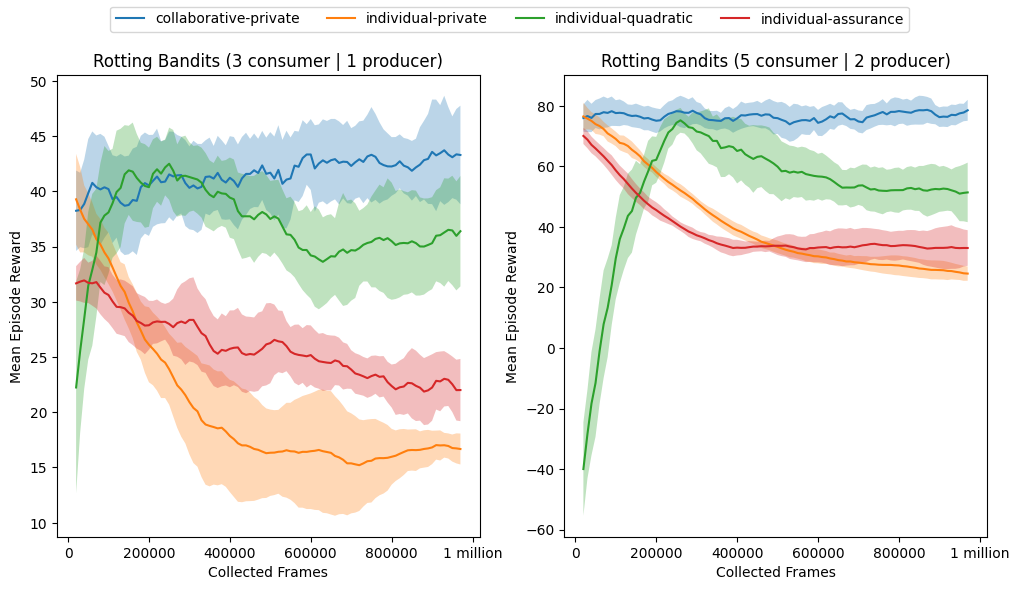

In [43]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, ((env_name, env_num_bandits, env_num_arms), settings) in enumerate(
    experiment_settings
):
    for env_reward_allocation, env_mechanism in settings:
        setting_train_rewards = []
        for repeat in range(num_experiment_repeats):
            key = (
                env_name,
                env_num_bandits,
                env_num_arms,
                env_reward_allocation,
                env_mechanism,
                repeat,
            )
            if key in experiments:
                setting_train_rewards.append(experiments[key]["train_rewards"])
        if setting_train_rewards:
            rewards_array = np.array(setting_train_rewards)
            mean_rewards = np.mean(rewards_array, axis=0)
            std_rewards = np.std(rewards_array, axis=0)

            # Smooth the curves using a moving average of window size 5
            ma_mean = moving_average(mean_rewards, 5)
            ma_std = moving_average(std_rewards, 5)
            # Adjust x_values to match the smoothed data (mode='valid' reduces length by 4)
            x_smoothed = np.arange(len(ma_mean)) * frames_per_batch + (
                frames_per_batch * 2
            )
            ax = axs[i]
            ax.plot(
                x_smoothed, ma_mean, label=f"{env_reward_allocation}-{env_mechanism}"
            )
            ax.fill_between(
                x_smoothed,
                ma_mean - ma_std,
                ma_mean + ma_std,
                alpha=0.3,
            )


def million_formatter(x, pos):
    if x >= 1e6:
        return f"{x / 1e6:.0f} million"
    return str(int(x))


for ax, exp in zip(axs, experiment_settings):
    ax.set_xlabel("Collected Frames")
    ax.set_ylabel("Mean Episode Reward")
    ax.set_title(f"Rotting Bandits ({exp[0][1]} consumer | {exp[0][2]} producer)")
    ax.xaxis.set_major_formatter(FuncFormatter(million_formatter))

# Collect legend handles and labels from all subplots
handles, labels = [], []
for ax in axs:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l
# Remove duplicates while preserving order
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc="upper center", ncol=len(by_label))

plt.show()


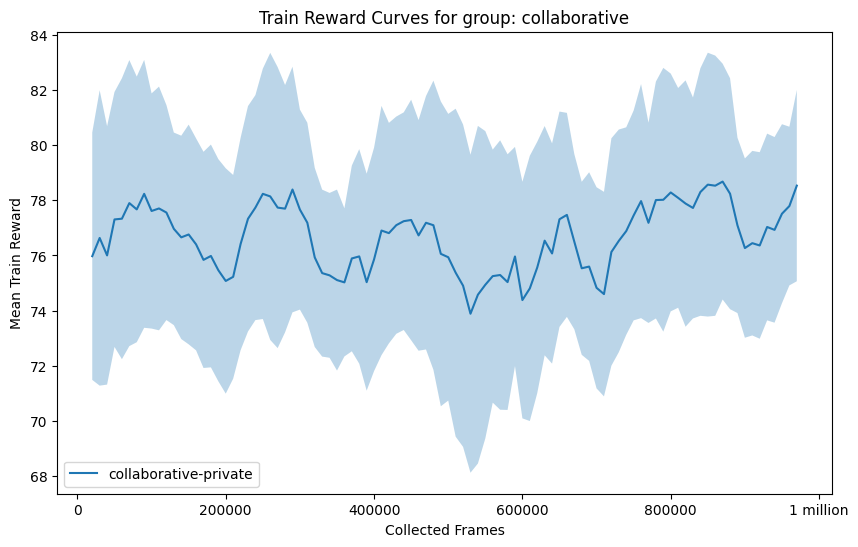

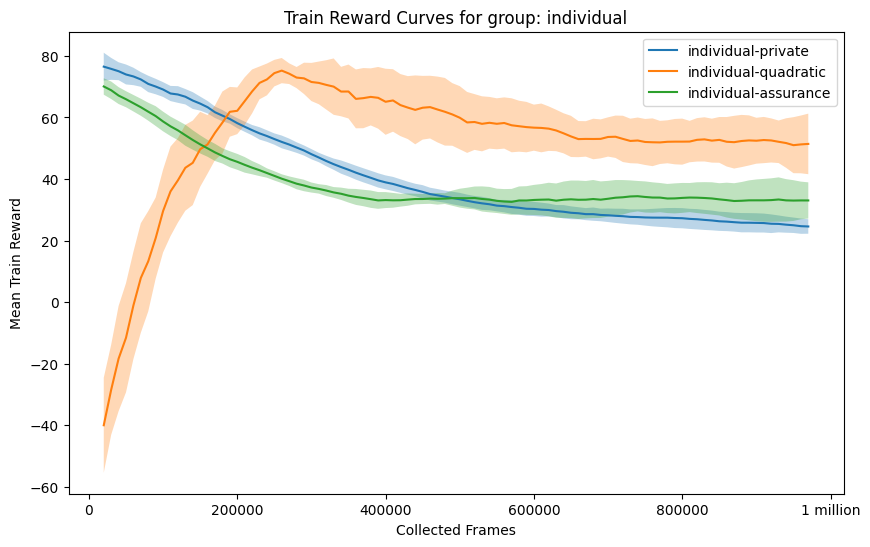

In [24]:
# Group the settings by the first element and create a new plot for each group.
unique_groups = sorted(set(s[0] for s in settings))
for group in unique_groups:
    fig, ax = plt.subplots(figsize=(10, 6))
    # Select the settings that belong to the current group.
    group_settings = [s for s in settings if s[0] == group]
    for setting in group_settings:
        setting_train_rewards = []
        for repeat in range(num_experiment_repeats):
            # Construct full key for experiment lookup.
            key = (
                env_name,
                env_num_bandits,
                env_num_arms,
                setting[0],
                setting[1],
                repeat,
            )
            if key in experiments:
                setting_train_rewards.append(experiments[key]["train_rewards"])
        if setting_train_rewards:
            rewards_array = np.array(setting_train_rewards)
            mean_rewards = np.mean(rewards_array, axis=0)
            std_rewards = np.std(rewards_array, axis=0)
            # Smooth the curves using a moving average.
            ma_mean = moving_average(mean_rewards, 5)
            ma_std = moving_average(std_rewards, 5)
            x_smoothed = np.arange(len(ma_mean)) * frames_per_batch + (
                frames_per_batch * 2
            )

            ax.plot(x_smoothed, ma_mean, label=f"{setting[0]}-{setting[1]}")
            ax.fill_between(x_smoothed, ma_mean - ma_std, ma_mean + ma_std, alpha=0.3)

    ax.set_xlabel("Collected Frames")
    ax.set_ylabel("Mean Train Reward")
    ax.set_title(f"Train Reward Curves for group: {group}")
    ax.legend()
    ax.xaxis.set_major_formatter(FuncFormatter(million_formatter))
    plt.show()
